# 1.Librerías

In [ ]:
%pip install lightgbm==4.4.0
%pip install optuna==3.6.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 21.4 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# 2.Datos

In [ ]:
#seteo carpeta de trabajo y archivo
dataset_path = 'home/ingceciliaconde/buckets/b1/datasets/'
modelos_path = 'home/ingceciliaconde/buckets/b1/datasets/modelos'
db_path = 'home/ingceciliaconde/buckets/b1/datasets/db'
dataset_file = 'competencia_02.csv.gz'


In [ ]:
#leo archivo
data = pd.read_csv(f"{dataset_path}/{dataset_file}")


In [ ]:
#semillas y valores de ganancia
semilla=[100183,200003,300017,700001,800011]
ganancia_acierto = 273000
costo_estimulo = 7000

In [ ]:
#meses
mes_train_all = [201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908,
                 201909, 201910, 201911, 201912, 202001, 202002, 202003, 202004,
                 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106]

mes_train_6 = [202101, 202102, 202103, 202104, 202105, 202106]
mes_train_12 = [202006, 202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106]
mes_test = 202108

In [ ]:
mes_train=mes_train_12 #si uso 6 meses, cambiar a mes_train_6 y si uso all, cambiar a mes_train_all

## Darle valor a las clases

In [ ]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

En particular, sumaremos la clase BAJA+1, que es estructuralmente muy similar a BAJA+2, para aumentar los casos positivos. Luego, compararemos los resultados obtenidos con los de la clase con la que hemos estado trabajando hasta ahora.

In [ ]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0) # solo baja +2
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1) #ambas bajas

In [ ]:
#filtrar por baja + 2 y mostrar clase ternaria clase binaria
data[data['clase_ternaria'] == 'BAJA+2'][['clase_ternaria', 'clase_binaria1', 'clase_binaria2']].head()


,clase_ternaria,clase_binaria1,clase_binaria2
164,BAJA+2,1,1
229,BAJA+2,1,1
1164,BAJA+2,1,1
1401,BAJA+2,1,1
1818,BAJA+2,1,1


# 3.Separa Test y Train

In [ ]:
train_data = data[data['foto_mes'] == mes_train] #capaz tiene que ser asi train_data = data[data['foto_mes'].isin(mes_train)]
test_data = data[data['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1'] #SOLO BAJA+2
y_train_binaria2 = train_data['clase_binaria2'] #TODAS LAS BAJAS
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

# 4.Funcion de Ganancia

In [ ]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

# Parámetros del modelos.
params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

# 5.Optimizacion del Modelo


In [ ]:
#optimizacion de hiperparametros
def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 100),
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3), # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 50, 2000), #cambie de 1 a 50
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semilla[0],
        'verbose': -1
    }
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # eligir la clase
                              weight=w_train)
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=1000, # modificar, subit y subir... y descomentar la línea inferior
        callbacks=[lgb.early_stopping(stopping_rounds=int(50 + 5 / learning_rate[0]))],
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semilla[0]
    )
    
    # Calculo la ganancia máxima y la mejor iteración donde se obtuvo dicha ganancia.
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5



In [ ]:
#almacenamiento de los resultados
storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = "exp_lgbm_v1"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

In [ ]:
study.optimize(objective, n_trials=100) # subir subir

## 5.1 Analisis de la optimizacion

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

In [ ]:
plot_slice(study)

In [ ]:
plot_contour(study)

In [ ]:
plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

# 7.Entrenamiento

---

Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

In [ ]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semilla[1],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model_lgb = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


Observamos variables mas importanes al modelo

In [ ]:
lgb.plot_importance(model_lgb, figsize=(10, 20))
plt.show()


Y si queremos tener las variables más importantes en forma de Dataframe:

In [ ]:
#extraccion de feature importances
importances = model_lgb.feature_importance()
features = model_lgb.feature_name() #ian
#creo un dataframe para que sea mas facil de visualizar
importance_df = pd.DataFrame({'feature': features, 'importance': importances})
#ordeno por importancia
importance_df = importance_df.sort_values('importance', ascending=False)

#show.
importance_df.head(100)

# Guardar el modelo

In [ ]:
# Primer dígito cuantos meses para atrás desde 06/21, segundo dígito número data drifting, tercer dígito número de entrenamiento.
#model_lgb.save_model(modelos_path + 'lgbm_{}_{}.txt'.format(cantidad_meses_train,ventana))
model_lgb.save_model(modelos_path + 'lgb_v4_semilla0.txt')

In [ ]:
#8. Volvemos a leer el modelo.
model_lgb = lgb.Booster(model_file= modelos_path + 'lgbm_{}_{}.txt'.format(cantidad_meses_train,ventana))

In [ ]:
#prmer subida a kaggle
#a. Importo librería.
from kaggle.api.kaggle_api_extended import KaggleApi
#b. Configura el API de Kaggle
api = KaggleApi()
api.authenticate()

In [ ]:
#L. Predecimos Agosto.
#i. Predecimos propiamente dicho.
predicciones = model_lgb.predict(X_test)
#ii. Le pegamos la probabilidad de ser "BAJA" a cada cliente.
X_test['Probabilidad'] = predicciones
#iii. Ordenamos a los clientes por probabilidad de ser "BAJA" de forma descendente.
tb_entrega = X_test.sort_values(by='Probabilidad', ascending=False)
#iv. Genero una lista de distintos cortes candidatos, para enviar a Kaggle.
cortes = range(9000,14000,20000)
#v. Generamos las distintas predicciones de clases a partir de los distintos cortes posibles.
num_subida_kaggle = 1
i = 0
for envios in cortes:
    #1. Le ponemos clase 1 ("BAJA") a los primeros "envios" con mayor probabilidad.
    tb_entrega['Predicted'] = 0
    tb_entrega.iloc[:envios, tb_entrega.columns.get_loc('Predicted')] = 1
    resultados = tb_entrega[["numero_de_cliente", 'Predicted']].reset_index(drop=True)
    
    print("Cantidad de clientes {}".format(envios))
    #2. Guardamos el archivo para Kaggle.
    nombre_archivo = "C2_CC_6_6_00{}.csv".format(num_subida_kaggle) #-X meses, con df de -X meses, número de intento.
    ruta_archivo= "{}/{}".format(exp_path,nombre_archivo)
    resultados.to_csv(ruta_archivo, index=False)
    
    num_subida_kaggle += 1
    i += 1
    
    #3. Envío a Kaggle.
    #a. Defino los parámetros claves.
    mensaje = f'Archivo {nombre_archivo}.LGBM meses train {cantidad_meses_train}, DF {ventana}, punto_corte: {envios}.'
    competencia = 'dm-ey-f-2024-segunda'
    #c. Subo la Submission.
    while i<=15:
        print(i)
        api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
        print("Submission successful!")
        break
    else:
        print("Esperamos 30 segundos...")
        time.sleep(30)
        api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
        print("Submission successful!")
        i= 0

#Corrida de Modelo optimidazo los hiperparametros

In [ ]:
# Obtener el mejor modelo
best_trial = study.best_trial
best_model_params = best_trial.params
print("Mejor modelo:", best_model_params)



Mejor modelo: {'num_leaves': 25, 'learning_rate': 0.02816161199350139, 'min_data_in_leaf': 1036, 'feature_fraction': 0.9600261328146125, 'bagging_fraction': 0.19249067068260242}


In [ ]:
ganancia = np.where(y_test_binaria1 == 1, ganancia_acierto, 0) - np.where(y_test_binaria1 == 0, costo_estimulo, 0)

idx = np.argsort(y_pred_lgb)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgb[idx]

ganancia_cum = np.cumsum(ganancia)

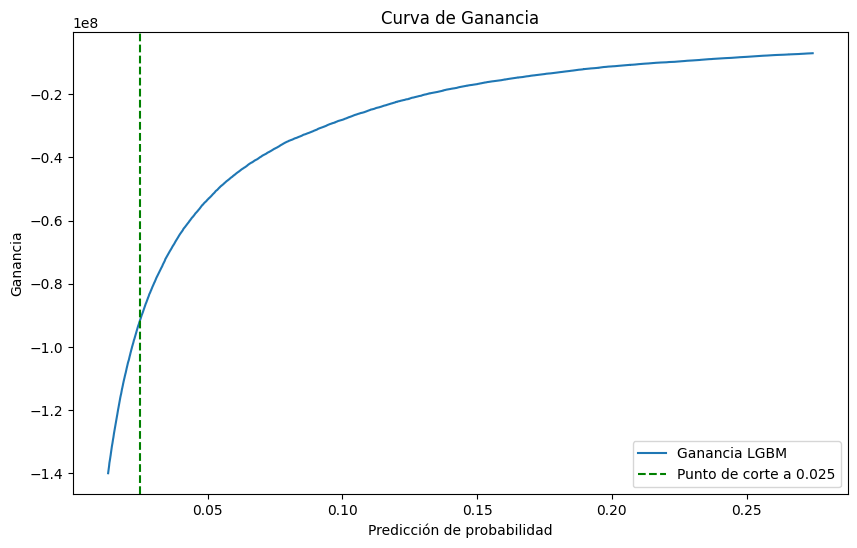

In [ ]:
piso_envios = 1000
techo_envios = 20000

plt.figure(figsize=(10, 6))
plt.plot(y_pred_lgm[piso_envios:techo_envios], ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.title('Curva de Ganancia')
plt.xlabel('Predicción de probabilidad')
plt.ylabel('Ganancia')
plt.axvline(x=0.025, color='g', linestyle='--', label='Punto de corte a 0.025')
plt.legend()
plt.show()

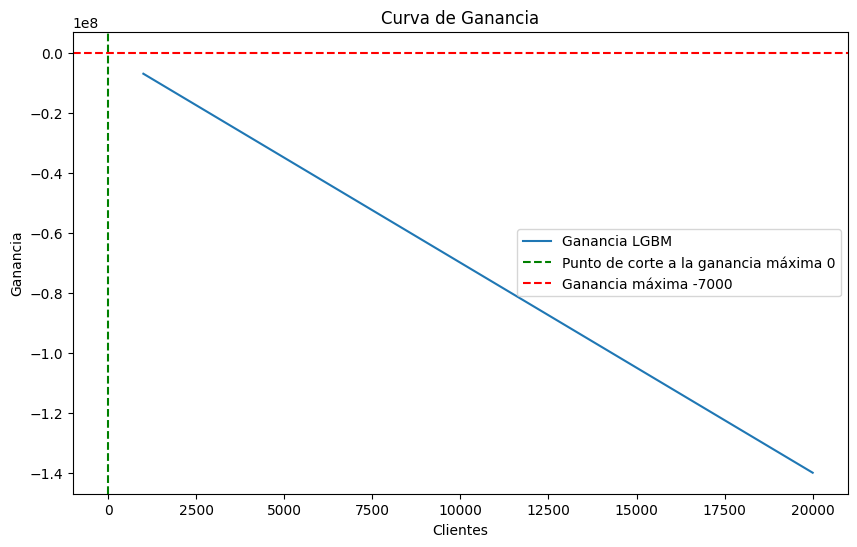

In [ ]:
piso_envios = 1000
techo_envios = 20000

ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()

In [ ]:
#armame un archivo desde y_pred_lgb, en donde la clase 1 es  si la probbilidad es mayor a 0.025 es 1, sino es 0
clientes_elegidos = X_test[['numero_de_cliente']].copy()
clientes_elegidos['Probabilidad'] = (y_pred_lgb).astype(float)
clientes_elegidos['Predicted'] = 0
clientes_elegidos.loc[clientes_elegidos['Probabilidad'] > 0.025, 'Predicted'] = 1
clientes_elegidos.loc[clientes_elegidos['Probabilidad'] <= 0.025, 'Predicted'] = 0
clientes_elegidos


,numero_de_cliente,Probabilidad,Predicted
5,249270768,0.005963,0
11,249280836,0.033739,1
17,249328898,0.000172,0
23,249345081,0.001662,0
29,249424500,0.054147,1
...,...,...,...
981941,1596907122,0.002422,0
981942,1596910624,0.001659,0
981943,1598058646,0.003900,0
981944,1598069799,0.006174,0


In [ ]:
#tengo que ordenar los clientes por Probabilidad de mayor a menor
clientes_elegidos = clientes_elegidos.sort_values(by='Probabilidad', ascending=False)
clientes_elegidos


,numero_de_cliente,Probabilidad,Predicted
234272,1069801754,0.953123,1
232076,1021275210,0.939649,1
857608,1461249806,0.938109,1
513139,612934991,0.933449,1
852830,1224175879,0.928016,1
...,...,...,...
694504,593346199,0.000002,0
504181,486163328,0.000002,0
62747,271767818,0.000002,0
514703,631044975,0.000002,0


In [ ]:
#los primeros 10000 quiero que sean 1 y el resto 0
clientes_elegidos.iloc[:10000, clientes_elegidos.columns.get_loc('Predicted')] = 1
clientes_elegidos

,numero_de_cliente,Probabilidad,Predicted
234272,1069801754,0.953123,1
232076,1021275210,0.939649,1
857608,1461249806,0.938109,1
513139,612934991,0.933449,1
852830,1224175879,0.928016,1
...,...,...,...
694504,593346199,0.000002,0
504181,486163328,0.000002,0
62747,271767818,0.000002,0
514703,631044975,0.000002,0


In [ ]:
clientes_elegidos.Predicted.value_counts()

,count
Predicted,
0,151821
1,13055


In [ ]:
clientes_elegidos.shape


(164876, 3)

In [ ]:
#borrar probabilidad
clientes_elegidos = clientes_elegidos.drop('Probabilidad', axis=1)

In [ ]:

# Creamos el dataframe para entregar


version = "v17"
clientes_elegidos.to_csv(f"{dataset_path}/solucion-ganancias-{version}.csv", index=False)

In [ ]:
#a. Importo librería.
from kaggle.api.kaggle_api_extended import KaggleApi
#b. Configura el API de Kaggle
api = KaggleApi()
api.authenticate()

In [ ]:
#L. Predecimos Agosto.
#i. Predecimos propiamente dicho.
predicciones = model_lgb.predict(X_test)
#ii. Le pegamos la probabilidad de ser "BAJA" a cada cliente.
X_test['Probabilidad'] = predicciones
#iii. Ordenamos a los clientes por probabilidad de ser "BAJA" de forma descendente.
tb_entrega = X_test.sort_values(by='Probabilidad', ascending=False)
#iv. Genero una lista de distintos cortes candidatos, para enviar a Kaggle.
cortes = range(9000,14000,200)
#v. Generamos las distintas predicciones de clases a partir de los distintos cortes posibles.
num_subida_kaggle = 1
i = 0
for envios in cortes:
    #1. Le ponemos clase 1 ("BAJA") a los primeros "envios" con mayor probabilidad.
    tb_entrega['Predicted'] = 0
    tb_entrega.iloc[:envios, tb_entrega.columns.get_loc('Predicted')] = 1
    resultados = tb_entrega[["numero_de_cliente", 'Predicted']].reset_index(drop=True)
    
    print("Cantidad de clientes {}".format(envios))
    #2. Guardamos el archivo para Kaggle.
    nombre_archivo = "K_OH_6_6_00{}.csv".format(num_subida_kaggle) #-X meses, con df de -X meses, número de intento.
    ruta_archivo= "{}/{}".format(exp_path,nombre_archivo)
    resultados.to_csv(ruta_archivo, index=False)
    
    num_subida_kaggle += 1
    i += 1
    
    #3. Envío a Kaggle.
    #a. Defino los parámetros claves.
    mensaje = f'Archivo {nombre_archivo}.LGBM meses train {cantidad_meses_train}, DF {ventana}, punto_corte: {envios}.'
    competencia = 'dm-ey-f-2024-segunda'
    #c. Subo la Submission.
    while i<=15:
        print(i)
        api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
        print("Submission successful!")
        break
    else:
        print("Esperamos 30 segundos...")
        time.sleep(30)
        api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
        print("Submission successful!")
        i= 0
        break